In [65]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

### VISUALIZE AND QUANTIZE 

In [64]:
"""
Variable: 
- time_data: "Specific times that acceleration was observed"
- acceleration_data: "Specific linear and angular acceleration at specific times"

Variable Shapes: 
- time_data = (4111, 1) = (# instances, 1 Time)
- acceleration_data = (4111, 6) = (# Instances, 6 acceleration columns)
"""

def load_data(file_name):
    return np.loadtxt(file_name)

# Append all of the gesture data which we will discretize the data 
for i in range(len(os.listdir("Data/ECE5242Proj2_train_additional-selected/"))):
    fname = os.listdir("Data/ECE5242Proj2_train_additional-selected/")[i]
    path = os.path.join("Data/ECE5242Proj2_train_additional-selected/", fname)
    gesture_data = load_data(path)

    if i == 0:
        time_data = gesture_data[:, 0][:, np.newaxis]
        acceleration_data = gesture_data[:, 1:]
    else:
        time_data = np.row_stack((time_data, gesture_data[:, 0][:, np.newaxis])) # NOT SURE IF THIS IS CORRECT
        acceleration_data = np.row_stack((acceleration_data, gesture_data[:, 1:]))

print(acceleration_data.shape, time_data.shape)

(4111, 6) (4111, 1)


In [71]:
print(np.amax(time_data))

4572.0


/Users/kennethalvarez/opt/anaconda3/envs/ECE5242/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


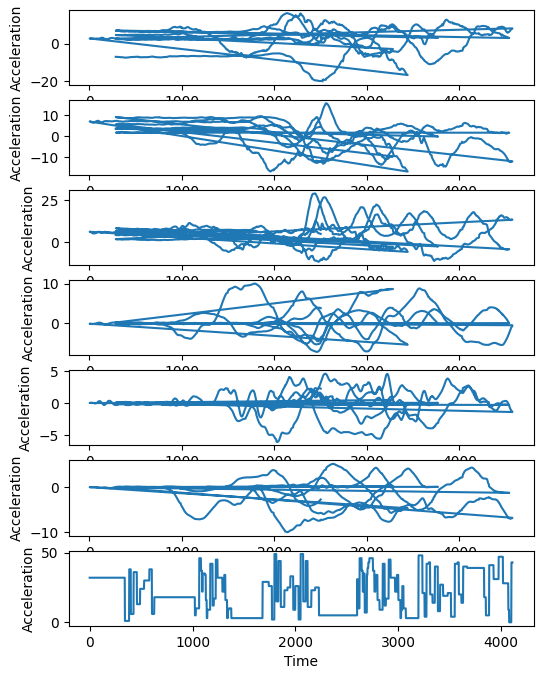

In [82]:
num_of_clusters = 50
observations = KMeans(n_clusters=num_of_clusters).fit_predict(acceleration_data)

# Plot the data
fig, axs = plt.subplots(nrows=7, ncols=1, sharex=False, sharey=False, figsize=(6, 8))

# Plot each channel in a separate subplot
for i, ax in enumerate(axs):
    if i < 6:
        ax.plot(time_data, acceleration_data[:, i])
        ax.set_xlabel('Time')
        ax.set_ylabel('Acceleration')
    else:
        ax.plot(observations)
        ax.set_xlabel('Time')
        ax.set_ylabel('Acceleration')

# # Adjust the layout and spacing of the subplots
fig.tight_layout()

# Show the plot
plt.show()